# Chance-Constrained Optimization and Linear Decision Rules

By Vladimir Dvorkin, a postdoctoral fellow at the Massachusetts Institute of Technology, Cambridge, MA, USA. April 15, 2022. 

## Motivating example 

In this tutorial, we will be working with the following optimization problem
\begin{align}
\underset{x}{\text{min}}\quad&c^{\top}x\\
\text{s.t.}\quad&Ax\geqslant b,
\end{align}
which minimizes a linear objective function by identifying the optimal value of vector $x\in\mathbb{R}^{n}$ among all feasible choices in a polyhedron with parameters $A\in\mathbb{R}^{m\times n}, b\in\mathbb{R}^{m}$.

Consider the following optimization data:
\begin{align}
c = \begin{bmatrix}1\\2\end{bmatrix},\quad A = \begin{bmatrix}1 & 1\\1 & 0\\0 & 1\end{bmatrix}, \quad b = \begin{bmatrix}12\\5\\6\end{bmatrix}
\end{align}

Let's solve this optimization problem using [JuMP](https://github.com/jump-dev/JuMP.jl) package and a free [Ipopt](https://github.com/jump-dev/Ipopt.jl) solver in Julia: 

In [1]:
using JuMP, Ipopt

function solve_det_model(opt_data)
    m, n = size(opt_data[:A])
    
    model = Model(optimizer_with_attributes(Ipopt.Optimizer, "print_level" => 0))
    
    @variable(model, x[1:n])
    
    @objective(model, Min, opt_data[:c]'*x)
    
    @constraint(model, opt_data[:A]*x .>= opt_data[:b])
    
    optimize!(model)
    @info("determenistic model terminates with status: $(JuMP.termination_status(model))")
    
    return sol = Dict(:x => JuMP.value.(x), :obj => JuMP.objective_value(model), :model => model)
end

opt_data = Dict(:A => [1 1;1 -0;0 1], :b => [12; 5; 6], :c => [1; 2]);

sol_det = solve_det_model(opt_data)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



┌ Info: determenistic model terminates with status: LOCALLY_SOLVED
└ @ Main In[1]:15


Dict{Symbol, Any} with 3 entries:
  :obj   => 18.0
  :model => A JuMP Model…
  :x     => [6.0, 6.0]

We will study the cases when the cost and the right-hand-side coefficients $c$ and $b$ are no longer fixed, but rather random. Assume that they depend on realizations of a random vector $\xi\in\mathbb{R}^{k}$, i.e., 
\begin{align}
c(\xi) = C\begin{bmatrix}1\\\xi\end{bmatrix},\quad\text{and}\quad b(\xi) = B\begin{bmatrix}1\\\xi\end{bmatrix},
\end{align}
where $C\in\mathbb{R}^{n\times k}$ and $B\in\mathbb{R}^{m\times k}$ are fixed matrices. Consider, for example, $k=2$, and that:
\begin{align}
c(\xi) = \begin{bmatrix}
1 & 1 & 0\\
2 & 0 & 1
\end{bmatrix}
\begin{bmatrix}1\\\xi_{1}\\\xi_{2}\end{bmatrix},\quad\text{and}\quad 
b(\xi) = 
\begin{bmatrix}
12 & 1 & -1\\
5 & 1 & 0\\
6 & 0 & 1\\
\end{bmatrix}
\begin{bmatrix}1\\\xi_{1}\\\xi_{2}\end{bmatrix},
\end{align}.

For zero-mean vector $\xi$, the first columns of matrices $C$ and $B$ define the mean value, and the remaining columns show the adjustment of these parameters with respect to random vector realizations. Note, that this representation is general enough to describe the uncertainty of optimization data. For now, we will consider that random vector which belongs to the normal distribution: 
\begin{align}
\xi\sim\mathcal{N}\left(\mu=
\begin{bmatrix}
0\\
0
\end{bmatrix},
\Sigma=
\begin{bmatrix}
1&0.5\\
0.5&1\\
\end{bmatrix}
\right),
\end{align}

with mean vector $\mu$ and covariance matrix $\Sigma$. When optimization data is uncertain, the deterministic solution in `sol_det` is no longer optimal. Indeed, let's count constraint violation for 10000 realizations of $\xi$:

In [2]:
using Distributions # need for uncertainty modeling  

# uncertainty data
ξ = Dict(:μ => [0; 0], :Σ => [1 0.5;0.5 1]);

# add new optimization data
opt_data[:B] = opt_data[:B] = [opt_data[:b] [1;1;0] [-1;0;1]]
opt_data[:C] = [opt_data[:c] [1;0] [0;1]];

# generate n realzaitions of ξ
n = 10000
ξ̃ = rand(MvNormal(ξ[:μ],ξ[:Σ]),n);
# add a dummy row of ones
ξ̃ = [ones(n)'; ξ̃];

# constraint violation count 
viol = 0
for s in 1:n
    sum(opt_data[:A]*sol_det[:x] .<= opt_data[:B]*ξ̃[:,s]) > 0 ? viol += 1 : NaN
end

@info("empirical constraint violation probability is $(round.(viol/n*100,digits=3))%")

┌ Info: empirical constraint violation probability is 83.72%
└ @ Main In[2]:22


The probability of constraint violation is as much as $\approx83$\%, which is untolerable. 

## Chance-constrained optimization using linear decision rules

To optimize vector $x$ under uncertainty, we put forth the following stochastic problem:
\begin{align}
\underset{x}{\text{min}}\quad&\mathbb{E}\left[c(\xi)^{\top}x(\xi)\right]\\
\text{s.t.}\quad&\mathbb{P}\left[Ax(\xi)\geqslant b(\xi)\right]\geqslant1-\varepsilon,
\end{align}
which minimizes the expected value of the cost function with respect to the distribution of $\xi$, subject to the *chance constraint*, which requires solution feasibility with probability $1-\varepsilon$, where $\varepsilon$ is a small prescribed parameter (e.g., 0.05). Note, that the chance-constrained programming is only one way to solve optimization problems under uncertainty. Alternatively, we could have used scenario-based stochastic programming or robust optimization techniques. Regardless of the chosen technique, this stochastic program is intractable because it constitutes an infinite-dimensional optimization problem. To mitigate its complexity, it has been proposed to approximate decision vector $x(\xi)$ by **linear decision rules** of the form:
\begin{align}
x(\xi) = X\begin{bmatrix}1\\\xi\end{bmatrix},
\end{align}
where $X\in\mathbb{R}^{n\times(k+1)}$ is a matrix of coefficients subject to optimization. Similarly to modeling uncertain optimization data, the first column of $X$ defines the mean value of decision vector $x(\xi)$, and the remaining columns compute the recourse with respect to uncertainty realizations. Linear decision rule representation allows for a tractable, finite-dimensional problem reformulation:

#### Objective function reformulation 

Substitute $c(\xi)$ and $x(\xi)$ with their finite-dimensional counterparts in the objective function and recall that $\mathbb{E}\left[\xi\xi^{\top}\right]=\text{Tr}\left[\Sigma + \mu\mu^{\top}\right]$, where $\text{Tr}$ is the matrix trace operator. The tractable reformulation of the objective function is then:
\begin{align}
\mathbb{E}\left[c(\xi)^{\top}x(\xi)\right] = \mathbb{E}\left[\left(C\begin{bmatrix}1\\\xi\end{bmatrix}\right)^{\top}X\begin{bmatrix}1\\\xi\end{bmatrix} 
\right]
= \text{Tr}\left[
\begin{bmatrix}
1 & \mathbb{0}^{\top}\\
\mathbb{0} & \Sigma
\end{bmatrix}
C^{\top}X
\right].
\end{align}
Later, we will verify that this is a linear function of optimization variables which is easy to optimize.

#### Sample-based chance constraint reformulation   

We will use the method by [Margellos et al.](https://ieeexplore.ieee.org/abstract/document/6727399) to reformulate chance constraint $\mathbb{P}\left[Ax(\xi)\geqslant b(\xi)\right]\geqslant1-\varepsilon$ in a tractable way. While this method is known to be conservative, it does not require the knowledge of the underlying distribution and is easy to implement in practice. The core idea is to enforce all $m$ entries of the chance constraint on $2^{k}$ vertices of the rectangular uncertainty set built upon available uncertainty samples. 

For $k=2$, we can visualize the rectangular set as follows.

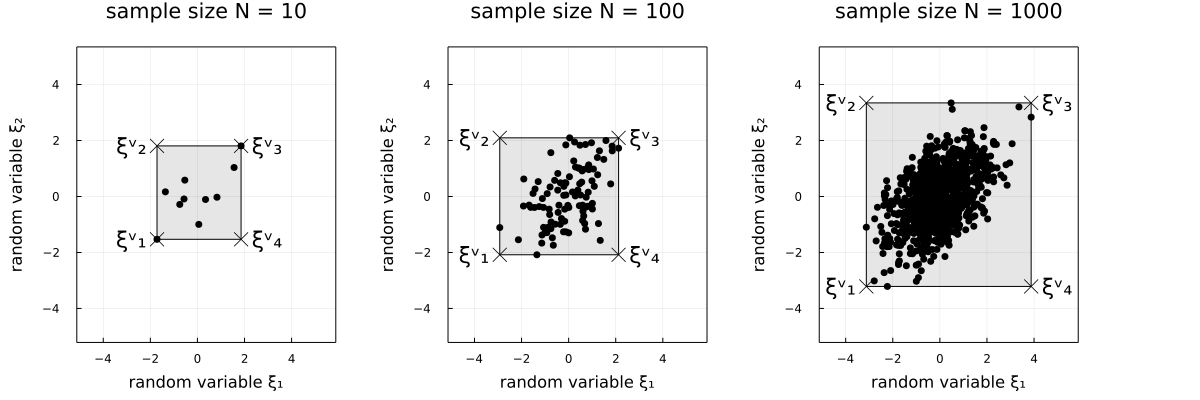

In [3]:
using Plots

ξ1 = rand(MvNormal(ξ[:μ],ξ[:Σ]),10)'    # N = 10
ξ2 = rand(MvNormal(ξ[:μ],ξ[:Σ]),100)'   # N = 100
ξ3 = rand(MvNormal(ξ[:μ],ξ[:Σ]),1000)'  # N = 1000

ylims = (min(minimum(ξ1[:,2]),minimum(ξ2[:,2]),minimum(ξ3[:,2]))-2,
         max(maximum(ξ1[:,2]),maximum(ξ2[:,2]),maximum(ξ3[:,2]))+2)
xlims = (min(minimum(ξ1[:,1]),minimum(ξ2[:,1]),minimum(ξ3[:,1]))-2,
         max(maximum(ξ1[:,1]),maximum(ξ2[:,1]),maximum(ξ3[:,1]))+2)

function plot_rectangular_set(ξ,xlims,ylims)
    plo = plot(Shape([minimum(ξ[:,1]),maximum(ξ[:,1]),maximum(ξ[:,1]),minimum(ξ[:,1])],
                     [minimum(ξ[:,2]),minimum(ξ[:,2]),maximum(ξ[:,2]),maximum(ξ[:,2])]),
                fillalpha=0.1,c=:black)
    scatter!(ξ[:,1],ξ[:,2],c=:black)
    plot!(legend=false)
    plot!(ylim=ylims)
    plot!(xlim=xlims)
    plot!(framestyle = :box)
    plot!(title = "sample size N = $(size(ξ,1))")
    plot!(xlabel = "random variable ξ₁")
    plot!(ylabel = "random variable ξ₂")
    annotate!(minimum(ξ[:,1])-0.5,minimum(ξ[:,2]), text("ξᵛ₁", :black, :right, 15))
    annotate!(minimum(ξ[:,1])-0.5,maximum(ξ[:,2]), text("ξᵛ₂", :black, :right, 15))
    annotate!(maximum(ξ[:,1])+0.5,maximum(ξ[:,2]), text("ξᵛ₃", :black, :left, 15))
    annotate!(maximum(ξ[:,1])+0.5,minimum(ξ[:,2]), text("ξᵛ₄", :black, :left, 15))
    scatter!([minimum(ξ[:,1]) minimum(ξ[:,1]) maximum(ξ[:,1]) maximum(ξ[:,1])],
             [minimum(ξ[:,2]) maximum(ξ[:,2]) maximum(ξ[:,2]) minimum(ξ[:,2])],
             mark=:x,msize=7,c=:black)
    return plo
end

plo_1 = plot_rectangular_set(ξ1,xlims,ylims)
plo_2 = plot_rectangular_set(ξ2,xlims,ylims)
plo_3 = plot_rectangular_set(ξ3,xlims,ylims)

l = @layout [
    a{0.3w} a{0.3w} a{0.3w}]

plo_final = plot(plo_1,plo_2,plo_3, layout = l, margin=7Plots.mm)
plot!(size=(1200,400))

Observe, as sample size increases, we account for more extreme realizations of random variables and expand the uncertainty set. In fact, there is a relation between the sample size $N$  and the feasibility guarantee of the chance constraint, as we show it next. 

Let $\xi^{v}\in\mathbb{R}^{2^{k}}$ be a vector of vertices of the rectangular uncertainty set (marked by $\times$ in the figure above). Then, the chance constraint $\mathbb{P}\left[Ax(\xi)\geqslant b(\xi)\right]\geqslant1-\varepsilon$ can be rewritten as
\begin{align}
Ax(\xi_{i}^{v})\geqslant b(\xi_{i}^{v}), \quad\forall i=1,\dots,2^{k},
\end{align}
which writes in linear decision rules as
\begin{align}
AX\xi_{i}^{v}\geqslant B\xi_{i}^{v}, \quad\forall i=1,\dots,2^{k}.
\end{align}

With a certain degree of confidence $(1-\beta)$, for some small prescribed parameter $\beta\in(0,1)$, this expression is equivalent to the original formulation $\mathbb{P}\left[Ax(\xi)\geqslant b(\xi)\right]\geqslant1-\varepsilon$, when the size $N$ of the sample from the underlying distribution is at least as much as
\begin{align}
N(\varepsilon,\beta) \geqslant \left \lceil \frac{1}{\varepsilon} \frac{e}{e-1} \left(2k-1+\ln\frac{1}{\beta}\right) \right \rceil,
\end{align}
where the ceil operator $\lceil x \rceil$ maps real number $x$ into the least succeeding integer, and where $e$ is the Euler's number.  

#### Implementation in Julia

Now, the tractable reformulation of the chance-constrained program takes the following form in linear decision rules:
\begin{align}
\underset{x}{\text{min}}\quad&\text{Tr}\left[
\begin{bmatrix}
1 & \mathbb{0}^{\top}\\
\mathbb{0} & \Sigma
\end{bmatrix}
C^{\top}X
\right]\\
\text{s.t.}\quad&AX\xi_{i}^{v}\geqslant B\xi_{i}^{v}, \quad\forall i=1,\dots,2^{k},
\end{align}
which can be implemented in Julia as follows.

In [5]:
using CDDLib, Polyhedra # need for computing vertices 
using LinearAlgebra     # need for general matrix manipulations

# function to compute vertices on N samples
function get_vertices(ξ,N)
    ξ̃ = rand(MvNormal(ξ[:μ],ξ[:Σ]),N)
    
    # compute extremes
    ξ̅ = maximum(ξ̃, dims=2)
    ξ̲ = minimum(ξ̃, dims=2)

    # build an optimization model
    model = Model()
    @variable(model, ξ_[1:length(ξ[:μ])])
    @constraint(model, ξ̲ .<= ξ_ .<= ξ̅)

    # create a polyhedron from the feasible set
    poly = polyhedron(model, CDDLib.Library(:exact))

    # obtain vertices
    vr = vrep(poly)
    vr = MixedMatVRep(vr)
    p = vr.V

    return float(p)
end

# function to solve the sample-based chance-constrained program
function solve_cc_sample_based(opt_data, ξ, ξᵛ, info)
    m, n = size(opt_data[:A]); k = size(ξ[:μ],1)
    
    model = Model(optimizer_with_attributes(Ipopt.Optimizer, "print_level" => 0))
    
    @variable(model, X[1:n,1:(k+1)])
    
    @objective(model, Min, tr([1 zeros(2)';zeros(2) ξ[:Σ]] * opt_data[:C]' * X))
    
    @constraint(model, cc[v=1:2^k], opt_data[:A] * vec(X*[1;ξᵛ[v,:]]) .>= opt_data[:B]*[1;ξᵛ[v,:]])
     
    optimize!(model)
    
    info == true ? @info("sample-based chance-constrained model terminates with status: $(JuMP.termination_status(model))") : NaN
    
    info == true ? @info("expected costs amount to $(round.(JuMP.objective_value(model),digits=1))") : NaN
    
    # evaluate empirical constraint violation probability on 10000 realizations
    n = 10000
    ξ̃ = rand(MvNormal(ξ[:μ],ξ[:Σ]),n);
    # add a dummy row of ones
    ξ̃ = [ones(n)'; ξ̃];
    # constraint violation count 
    viol = 0
    for s in 1:n
        sum((opt_data[:A]*JuMP.value.(X) .- opt_data[:B])*ξ̃[:,s] .<= -1e-6) > 0 ? viol += 1 : NaN
    end

    info == true ? @info("empirical constraint violation probability is $(round.(viol/n*100,digits=3))%") : NaN
    
    return sol = Dict(:X => JuMP.value.(X), :obj => JuMP.objective_value(model), :viol => round.(viol/n*100,digits=3))
end

# function compute the required minimum sample size
N(ε,β)= Int(ceil(1/ε * ℯ/(ℯ-1) * (2*size(ξ[:μ],1) - 1 + log(1/β))))

# experiment settings: we set theoretical violation probability and confidence value to 0.05
set = Dict(:ε => 0.05, :β => 0.05)

ξᵛ = get_vertices(ξ,N(set[:ε],set[:β]))

sol_sto_sb = solve_cc_sample_based(opt_data, ξ, ξᵛ, true)

┌ Info: sample-based chance-constrained model terminates with status: LOCALLY_SOLVED
└ @ Main In[5]:42
┌ Info: expected costs amount to 22.0
└ @ Main In[5]:44
┌ Info: empirical constraint violation probability is 0.23%
└ @ Main In[5]:57


Dict{Symbol, Any} with 3 entries:
  :X    => [8.57723 1.0 -1.14214; 6.0 1.17635e-10 1.0]
  :obj  => 22.0062
  :viol => 0.23

#### Interpretation of the sample-based chance-constrained solution 

The empirical constraint violation probability is smaller than the prescribed theoretical violation probability $\varepsilon$, meaning that the feasibility guarantee of the chance constraint hold. Having this guarantee comes at the expense of the additional costs (the expected value tends to be larger than the deterministic solution).

The feasibility is achieved thanks to linear decision rules that adjust the vector $x(\xi)$ of the optimal solution respecting uncertainty realizations. The optimal linear decision rules take the following values:

In [6]:
display(sol_sto_sb[:X])

2×3 Matrix{Float64}:
 8.57723  1.0          -1.14214
 6.0      1.17635e-10   1.0

Observe, that in this specific case, the solution is very sensitive to realizations of the right-hand-side coefficients $b$ (column 3 of $X$), and is insensitive to the uncertainty of cost coefficients $c$ (column 2 of $X$).

In chance-constrained programming, there exist inherent trade-offs between the expected cost and the feasibility of optimization solution. We can illustrate these trade-offs as follows:

In [7]:
macro dotimes(n, body)
  quote
    for i = 1:$(esc(n))
      $(esc(body))
    end
  end
end

# solve cc program 500 times and save :obj and :viol parameters for ε = 10%, 5%, 1% and 0.1%

n = 500

results_ε_10 = [];
@dotimes n push!(results_ε_10,[i for i in getindex.(Ref(solve_cc_sample_based(opt_data, ξ, get_vertices(ξ,N(0.1,set[:β])), false)), (:obj, :viol))])

results_ε_05 = [];
@dotimes n push!(results_ε_05,[i for i in getindex.(Ref(solve_cc_sample_based(opt_data, ξ, get_vertices(ξ,N(0.05,set[:β])), false)), (:obj, :viol))])

results_ε_01 = [];
@dotimes n push!(results_ε_01,[i for i in getindex.(Ref(solve_cc_sample_based(opt_data, ξ, get_vertices(ξ,N(0.01,set[:β])), false)), (:obj, :viol))])

results_ε_001 = [];
@dotimes n push!(results_ε_001,[i for i in getindex.(Ref(solve_cc_sample_based(opt_data, ξ, get_vertices(ξ,N(0.001,set[:β])), false)), (:obj, :viol))])

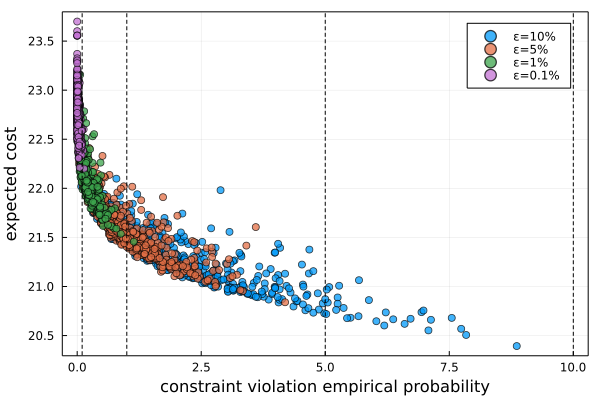

In [8]:
# plot cost-feasibility trade-offs
plo = scatter([results_ε_10[i][2] for i in 1:n], [results_ε_10[i][1] for i in 1:n], alpha = 0.75, label = "ε=10%")
scatter!([results_ε_05[i][2] for i in 1:n], [results_ε_05[i][1] for i in 1:n], alpha = 0.75, label = "ε=5%")
scatter!([results_ε_01[i][2] for i in 1:n], [results_ε_01[i][1] for i in 1:n], alpha = 0.75, label = "ε=1%")
scatter!([results_ε_001[i][2] for i in 1:n], [results_ε_001[i][1] for i in 1:n], alpha = 0.75, label = "ε=0.1%")
plot!(framestyle=:box)
plot!(ylabel="expected cost", xlabel="constraint violation empirical probability")
vline!([0.1,1,5,10],label=false, linestyle=:dash, c=:black)

This plot confirms that stronger feasibility guarantees come at the expense of the increasing expected cost. In addition, recall that we set confidence parameter $\beta=0.05$, meaning that our feasibility guarantee must work in at least $(1-\beta)=95\%$ cases. This is indeed the case, as only a few realizations are outside of their respected guarantee limits (dashed vertical lines). 

#### Analytic (second-order cone) reformulation of chance constraint

Instead of relying on samples, we can reformulate chance constraint $\mathbb{P}\left[Ax(\xi)\geqslant b(\xi)\right]\geqslant1-\varepsilon$ analytically, in a sample-free fashion. First, observe that this is a *joint* chance constraints, as it is enforced on $m$ inequalities. Before proceeding to analytic reformulations, we need to split it into *individual* chance constraints. That is, the split the joint chance constraint into into the following $m$ individual constraints:
\begin{align}
    \mathbb{P}\left[A_{i}^{\top}x(\xi)\geqslant b_{i}(\xi)\right]\geqslant 1-\overline{\varepsilon}_{i},\quad \forall i =1,\dots,m,
\end{align}
where $\overline{\varepsilon}_{i}$ is an individual prescribed probability of constraint violation. When $\sum_{i=1}^{m}\overline{\varepsilon}_{i}=\varepsilon$, this splitting constitutes a [Bonferroni](http://www.optimization-online.org/DB_FILE/2017/02/5860.pdf) approximation of the joint chance constraint. A typical choice is $\overline{\varepsilon}_{i}=\varepsilon/m$. Indeed, it is easy verify when $\overline{\varepsilon}_{i}=\varepsilon/m$ holds for each of $m$ constraints, the probability of their joint violation is no greater than $\sum_{i=1}^{m}\overline{\varepsilon}_{i} = \sum_{i=1}^{m}\varepsilon/m=\varepsilon$. 

The advantage of the analytic reformulation is that it allows for "cutting" unlikely extreme realizations of random variable $\xi$ (e.g., at the vertices of the rectangular uncertainty set) and for factoring in correlations (e.g., non-diagonal elements of covariance $\Sigma$). The core idea of this approximation is to factor in only those uncertainty realizations, which are within a confidence ellipsoid (parametrized by $\varepsilon$), and disregard all realizations outside the ellipsoid. To illustrate this, let's plot confidence ellipsoids for random vector $\xi$ for varying $\varepsilon$: 

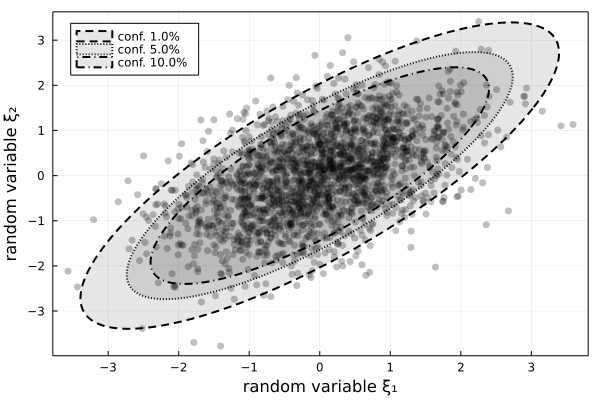

In [9]:
# function to plot ellipsoidic uncertainty set
function plot_ellipsoidic_set(ξ,ε)
    plot!(t -> sqrt(-2 * log(ε)) * ξ[:Σ][1,:]' * [ cos(t), sin(t) ] + ξ[:μ][1],
          t -> sqrt(-2 * log(ε)) * ξ[:Σ][2,:]' * [ cos(t), sin(t) ] + ξ[:μ][2],
          0,2*pi, 
          seriestype = [:shape],linestyle=:auto,w=2,
          fill=:black,fillalpha=0.1,c=:black, label = "conf. $(ε*100)%")  
end

# extract and plot samples from the underlying distribution 
ξ̃ = rand(MvNormal(ξ[:μ],ξ[:Σ]),2000)   
scatter(ξ̃[1,:],ξ̃[2,:],alpha=0.25,c=:black,framestyle=:box,
        xlabel = "random variable ξ₁", ylabel = "random variable ξ₂", label=false, legend=:topleft)
# plot ellipsoidic uncertainty sets for ε = 1%, 5% and 10%
plot_ellipsoidic_set(ξ,0.01)
plot_ellipsoidic_set(ξ,0.05)
plot_ellipsoidic_set(ξ,0.10)

The analytic, ellipsoid reformulation of chance constraints is achieved using second-order cone programming (refer to [Ben-Tal](https://press.princeton.edu/books/hardcover/9780691143682/robust-optimization) and [Shapiro&Nemirovski](https://www2.isye.gatech.edu/~nemirovs/SIOPT_Bern_2006.pdf)), and for each individual chance constraint written in linear decision rule, i.e.,
\begin{align}
    \mathbb{P}\left[A_{i}^{\top}X\xi\geqslant B_{i}^{\top}\xi\right]\geqslant 1-\overline{\varepsilon}_{i},
\end{align}
it takes the form:
\begin{align}
    z(\overline{\varepsilon}_{i})\left\lVert 
    \begin{bmatrix}
    0 & \mathbb{0}^{\top}\\
    \mathbb{0} & F
    \end{bmatrix}
    [AX-B]_{i}^{\top}\right\rVert\leqslant 
    [AX-B]_{i}\begin{bmatrix}
    1\\
    \mu
    \end{bmatrix},
\end{align}
where $z(\overline{\varepsilon}_{i})$ is the so-called safety margin to internalize the confidence parameter $\varepsilon$, and $F$ is a *factorization* (e.g., Cholesky factorization) of covariance matrix $\Sigma$, meaning $FF^{\top}=\Sigma$. Observe that the left-hand-side is indeed a margin which is subtracted from the mean value (right-hand-side) to ensure constraint feasibility under different uncertainty realizations. When a distribution of $\xi$ is Normal, safety margin $z(\overline{\varepsilon}_{i})$ is the inverse of the standard Normal distribution at quantile $\overline{\varepsilon}_{i}$ (table number). When the distribution is unknown but the mean and covariance are know, one may tune $z$ to insure distributional robustness. For example, one can use Chebyshev inequality and set $z(\overline{\varepsilon}_{i})=\sqrt{\frac{1-\overline{\varepsilon}_{i}}{\varepsilon_{i}}}$ to guarantee solution feasibility for any distributional shape for the given mean and covariance. In Julia, the analytic chance constraint programming realizes as follows:

In [10]:
using COSMO

# function to compute the inverse of the standard Normal distribution
z(x) = quantile(Normal(0,1),1-x)

# function to solve thechance-constrained program using analytic reformulation
function solve_cc_analytic(opt_data, ξ, set, info)
    m, n = size(opt_data[:A]); k = size(ξ[:μ],1)

    model = Model(optimizer_with_attributes(COSMO.Optimizer, "verbose" => false, "eps_abs" => 1e-8))

    @variable(model, X[1:n,1:(k+1)])

    @objective(model, Min, tr([1 zeros(2)';zeros(2) ξ[:Σ]] * opt_data[:C]' * X))

    @constraint(model, SoC[i=1:m], [(opt_data[:A]*X - opt_data[:B])[i,:]'*[1;ξ[:μ]];
        z(set[:ε]/m)*[0 zeros(k)'; zeros(k) cholesky(ξ[:Σ]).L]*(opt_data[:A]*X - opt_data[:B])[i,:]] in SecondOrderCone())

    optimize!(model)

    info == true ? @info("sample-based chance-constrained model terminates with status: $(JuMP.termination_status(model))") : NaN

    # evaluate empirical constraint violation probability on 10000 realizations
    n = 10000
    ξ̃ = rand(MvNormal(ξ[:μ],ξ[:Σ]),n);
    # add a dummy row of ones
    ξ̃ = [ones(n)'; ξ̃];
    # constraint violation count 
    viol = 0
    for s in 1:n
        sum((opt_data[:A]*JuMP.value.(X) .- opt_data[:B])*ξ̃[:,s] .<= -1e-6) > 0 ? viol += 1 : NaN
    end

    info == true ? @info("empirical constraint violation probability is $(round.(viol/n*100,digits=3))%") : NaN
    
    return sol = Dict(:X => JuMP.value.(X), :obj => JuMP.objective_value(model), :viol => round.(viol/n*100,digits=3))    
end 

sol_sto_an = solve_cc_analytic(opt_data, ξ, set, true)

┌ Info: sample-based chance-constrained model terminates with status: OPTIMAL
└ @ Main In[10]:21
┌ Info: empirical constraint violation probability is 6.33%
└ @ Main In[10]:34


Dict{Symbol, Any} with 3 entries:
  :X    => [7.46526 0.691307 -1.11109; 6.0 7.75818e-14 1.0]
  :obj  => 20.601
  :viol => 6.33

Let's compare the solutions of the sample-based and analytic reformulation of chance constraint. First observe, that the analytic formulation is less conservative than that of the sample-based one:

In [11]:
@show sol_sto_sb[:obj], sol_sto_an[:obj]

(sol_sto_sb[:obj], sol_sto_an[:obj]) = (22.006157217979453, 20.601024528379565)


(22.006157217979453, 20.601024528379565)

We can also illustrate it by comparing analytic and sample-based solutions in terms of the trade-off between the expected cost and solution feasibility

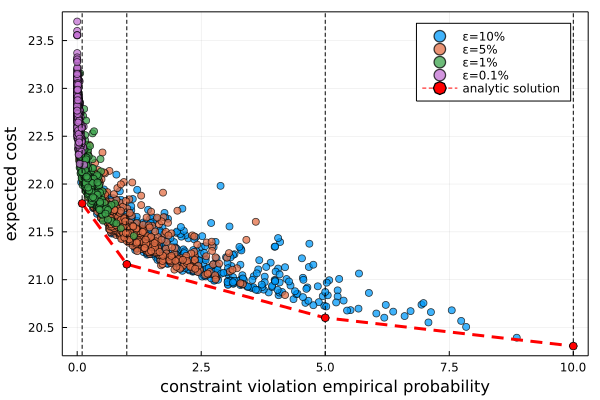

In [12]:
set[:ε] = 0.001
sol_sto_an_001 = solve_cc_analytic(opt_data, ξ, set, false)
set[:ε] = 0.01
sol_sto_an_01  = solve_cc_analytic(opt_data, ξ, set, false)
set[:ε] = 0.05
sol_sto_an_05  = solve_cc_analytic(opt_data, ξ, set, false)
set[:ε] = 0.10
sol_sto_an_10  = solve_cc_analytic(opt_data, ξ, set, false)

plot(plo)
plot!([0.1;1;5;10],[sol_sto_an_001[:obj];sol_sto_an_01[:obj];sol_sto_an_05[:obj];sol_sto_an_10[:obj]],
      linewidth=3,c=:red,linestyle=:dash,label = "analytic solution",mark=:o)

Two provide the same feasibility guarantee, the two methods may optimize linear decision rules differently:

2×3 Matrix{Float64}:
 8.57723  1.0          -1.14214
 6.0      1.17635e-10   1.0

2×3 Matrix{Float64}:
 7.46526  0.691307     -1.11109
 6.0      7.75818e-14   1.0

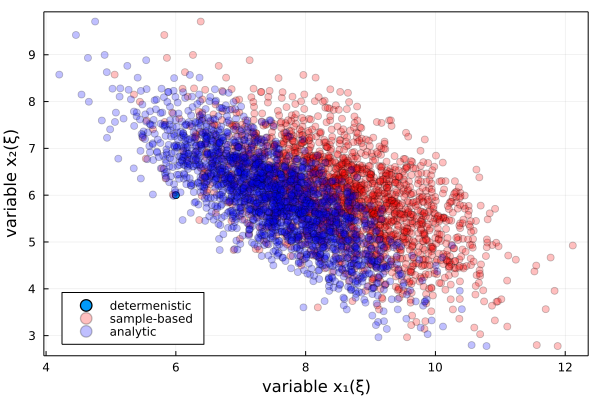

In [13]:
# display LDR solutions
display(sol_sto_sb[:X])
display(sol_sto_an[:X])

# determenistic solution 
scatter([sol_det[:x][1]],[sol_det[:x][2]], label = "determenistic")

# extract and plot samples from the underlying distribution 
ξ̃ = rand(MvNormal(ξ[:μ],ξ[:Σ]),2000)
ξ̃=[ones(2000)';ξ̃]

# plot sample-based out-of-sample solutions
scatter!( (sol_sto_sb[:X]*ξ̃)[1,:],(sol_sto_sb[:X]*ξ̃)[2,:],alpha=0.25,c=:red,framestyle=:box,
        xlabel = "variable x₁(ξ)", ylabel = "variable x₂(ξ)", label="sample-based", legend=:topleft)
# plot analytic out-of-sample solutions
scatter!((sol_sto_an[:X]*ξ̃)[1,:],(sol_sto_an[:X]*ξ̃)[2,:],alpha=0.25,c=:blue,framestyle=:box,
        xlabel = "variable x₁(ξ)", ylabel = "variable x₂(ξ)", label="analytic", legend=:topleft)
plot!(legend=:bottomleft)

To do list:
* LDR sub-optimality
* Multi-stage LDR